# RA Diagnosis Extraction with Machine Learning
This notebook is built for extracting the diagnosis from format-free textfields of Electronic Medical Health records. 
- Feel free to make some adjustments that better correspond with your data

In [7]:
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append('/exports/reum/tdmaarseveen/modules')
import scipy
from yellowbrick import __version__ as yb_vers
from sklearn import __version__ as sk_vers
import NLP_functions as func
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
import re
import random
import pickle
import xgboost as xgb
import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('scipy version:\t\t' + scipy.__version__)
print('pattern version:\t' + pat_vers)
print('yellowbrick version:\t' + yb_vers)
print('xgb version:\t\t' + xgb.__version__)
print('seaborn version:\t' + sns.__version__)
print('pickle version:\t\t' + pickle.format_version)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.17.0
sklearn version:	0.21.2
scipy version:		1.1.0
pattern version:	3.6
yellowbrick version:	0.9.1
xgb version:		0.90
seaborn version:	0.9.0
pickle version:		4.0


## Step 1: Cleaning Data with NLP methods
To clean our sample data we will apply the following Natural Language Processing algorithms:
- Word segmentation: words are split on whitespace -> special characters are removed
- lemmatization: words are returned to the root form (if word is in corpus) - default= Dutch (nl)
- Typocorrection
- XML artefact removal

These function can be useful, depending on the quality of the data

### 1.1 Open raw file
Our sample table consists of two columns split by pipes ('|'). We have the following columns: 
- text= free text field from the EMR (Conclusion)
- annotation = associated label:
    - 'True' = RA-case
    - 'False' = not an RA-case

In [299]:
radiag_df = pd.read_csv(r'sample_data/dummydata.csv', sep='|')
print('nr of entries: ', len(radiag_df))
radiag_df.head()

nr of entries:  1000


,annotation,text,patientid
0,False,met po fa voor ra artritis pip gewricht en voe...,134.0
1,False,artritiid onder prednison mgmogelijk pmrsl rus...,4.0
2,True,vanwege duizeligheid co omgezet naar tc derhal...,213.0
3,False,x minimaal progressie voet tov knie enig artro...,246.0
4,True,vrij remissieal meer dan jaar bestanen artralg...,455.0


### 1.2 Renaming columns & labels

1. We will change the column names 'annotation' and 'text' to 'Outcome' and 'Text' respectively. From now on we can only refer to the adjusted column names.
2. Furthermore, we will apply a different standard for the label data (TRUE -> y and FALSE -> n)

In [300]:
radiag_df = radiag_df.rename(columns={"annotation": "Outcome", "text": "Text"})
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x: 'y' if x == True else 'n')
radiag_df[['Text', 'Outcome']].head()

,Text,Outcome
0,met po fa voor ra artritis pip gewricht en voe...,n
1,artritiid onder prednison mgmogelijk pmrsl rus...,n
2,vanwege duizeligheid co omgezet naar tc derhal...,y
3,x minimaal progressie voet tov knie enig artro...,n
4,vrij remissieal meer dan jaar bestanen artralg...,y


### 1.3 Typocorrection - Create Dutch dictionary for EMR [Optional]
1. Source for dictionary files (multiple languages) - https://github.com/titoBouzout/Dictionaries 
2. If left unchanged this step only applies if you're working with Dutch data

In [301]:
def readDictionary(location):
    return list(pd.read_csv(location, sep='/').index)

l_custom= list(pd.read_csv('corpus/Custom.dic', sep=';')) # custom dutch clinical vocab
l_dutch= readDictionary('corpus/Dutch.dic') # dutch dictionary

# combine dutch dictionary with the custom dict
l_dutch.extend(l_custom) 
l_new = [func.removeAccent(func.processArtefactsXML(i)) for i in l_dutch]
print('Dic:\t\t\t', str(len(l_new)))
l_new = [i for i in l_new if i.lower() == i]
l_new = [i for i in l_new if len(i) > 2]
print('Dic (names removed):\t', str(len(l_new)))

Dic:			 173649
Dic (names removed):	 138487


### 1.4 Preprocessing - Word segmentation and lemmatizing 
The typo correction step is currently muted on purpose, because this step only applies if you're working with Dutch data

In [302]:
import time

radiag_df['Text'] = radiag_df['Text'].apply(lambda x : func.processArtefactsXML(str(x)))
radiag_df['Text'] = radiag_df['Text'].apply(lambda x : func.simpleCleaning(x, lemma=False))

# Apply TypoCorrection  
  #  typocor = func.TypoCorrection(np.array(l_new)) # provide word list
  #  t0 = time.time()
  #  radiag_df['Text'] = radiag_df['Text'].apply(lambda x : typocor.correct(x))
  #  t1 = time.time()
  #  print('Time for TypoCorrection (n=' + str(len(radiag_df)) + ') : ' + str(t1-t0))

radiag_df['Text'] = radiag_df['Text'].apply(lambda x : func.lemmatizingText(x, lan='nl')) # 'en' for english & 'de' for german
radiag_df=radiag_df.fillna('')

# Save autocorrected dataframe
radiag_df.to_csv(r'sample_data/autocorrect_dummydata.csv', sep='|', index=False)

## Step 2: Structuring the data

### 2.1 Open the preprocessed file
You can skip the above steps if you already have a preprocessed file

In [303]:
radiag_df = pd.read_csv(r'sample_data/autocorrect_dummydata.csv', sep='|')
radiag_df=radiag_df.fillna('')
radiag_df[['Text', 'Outcome']].head()

,Text,Outcome
0,met po fa voor ra artritis pip gewricht en voe...,n
1,artritiid onder prednison mgmogelijk pmrsl rus...,n
2,vanwege duizeligheid co omgezet naar tc derhal...,y
3,x minimaal progressie voet tov knie enig artro...,n
4,vrij remissieal meer dan jaar bestaan artralgi...,y


### 2.2 Balancing classes in data (Proportion RA cases vs. non cases) - Optional
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 
- Optional: Whether or not you want to balance the classes depends on the expected prevalence of the cases in the test data. 
- You could also choose to balance the classes in a different way (eg: 1:5) but it should always correspond with the expected prevalence in the test set. Choose the desired nr of samples by changing nr_of_samples

FYI: the data is not balanced by default 

In [304]:
balance = False
nr_of_samples = len(radiag_df[radiag_df['Outcome']=='y'])

if (balance):
    df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(n=nr_of_samples, random_state=SEED)
    equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
    radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 2.3 Splitting annotated set on both the textual data and the corresponding label (Y)

In [331]:
radiag_df = radiag_df.sample(frac=1, random_state=SEED) # random shuffle

X = radiag_df['Text'].values
y = radiag_df['Outcome'].values
y_b = np.array([func.binarize(val) for val in y])

### 2.4 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

(490, 510)


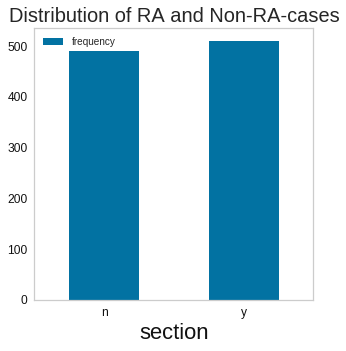

In [306]:
from collections import Counter

labels, values = zip(*Counter(y).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


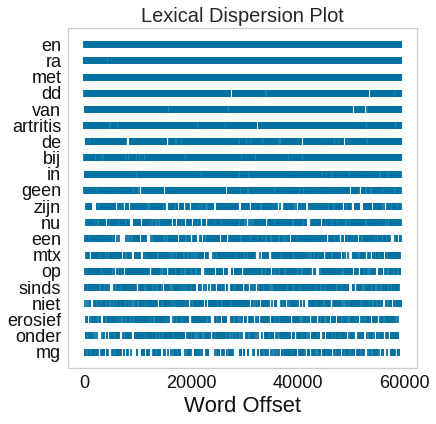

In [307]:
func.plotLexicalDispersion(X, nr_features=20, ngram_range=(1,1))

#### Plot: Feature distribution

<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

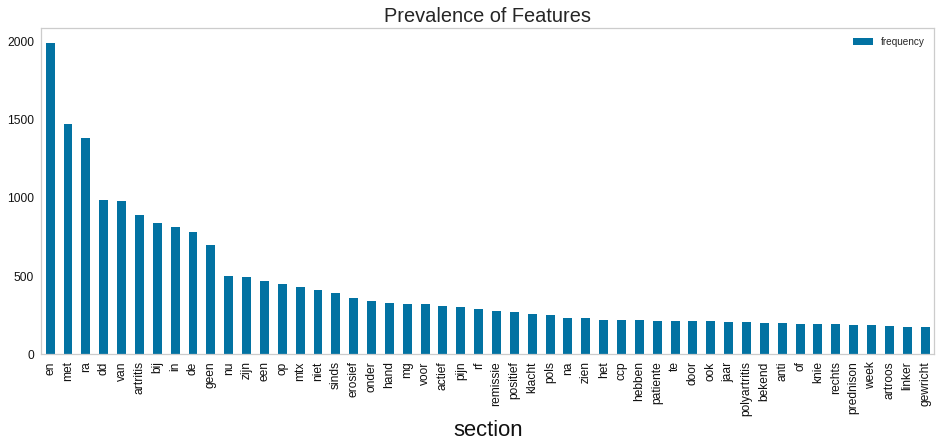

In [308]:
func.plotSampleDistribution(X, nr_features=50) 

## Step 3: Building the Pipeline & Fitting models
import all of the classifiers that you want to apply/compare

### 3.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [309]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
# from xgboost import XGBClassifier

### 3.2 Initialize the different models

#### Word Matching
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra' (Dutch)

In [310]:
import TextClassification as tc

l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']

WordMatching = tc.CustomBinaryModel(l_targets)

#### Initialize classifiers
All methods except for the naive word matching method require vectorized data. Hence, the classifiers are accompanied with a TfidfVectorizer function 

In [311]:
SEED=26062019
models = [
    # 0
    WordMatching,
    # Naive Bayes - 1
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 2
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 3
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 4
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 5 - NuSVC probability
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=SEED)),
            ]),
    # Random Forest 6
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 7
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', DummyClassifier(random_state=SEED)),
            ]),
    ]

#### Naming the models
Provide each of your methods with a relevant or recognizable name -> by providing a list

Be careful: keep the same order as above

In [312]:
names = ['Word Matching', 'Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'Decision Tree', 'SVM', 'Random Forest', 'Dummy']

### 3.3: Fitting the classifiers

The models can now be applied on the trainingsdata. 

Consider adjusting the default parameters to your liking:
- seed : pseudo random number generator, to ensure replication
- pathway to preferred directory 
- nr of iterations a.k.a. folds to assure a robust performance evaluation
- binarize label -> label will be changed to either 0 or 1, so you should mention how the true labels are encoded (default=y)
- palette : list of [colorcodes](https://matplotlib.org/2.0.2/api/colors_api.html)

Furthermore the function assignPalette() is applied : automatically assigns a classifier to a color, to ensure the same color over multiple plots


In [385]:
import TextClassification as tc
import importlib
importlib.reload(tc)

tm = tc.TextClassification(X, y, models, names)

tm.setSeed(26062019)
tm.setOutputPath(r'output_files/')
tm.binarizeLabel(y, true_label='y')
tm.assignPalette()
tm.setIterations(10)

tm.fitModels()

{'Dummy': 'black', 'Word Matching': 'r', 'Decision Tree': 'g', 'Gradient Boosting': 'c', 'Neural Networks': 'b', 'Random Forest': 'indigo', 'Naive Bayes': 'y', 'SVM': 'magenta'}

General settings for training/testing:
Method = Cross Validation 10-fold
	fraction test:	 0.5 

loading model:  Word Matching
Word Matching is assumed to be a word matching method and is therefore not fitted
loading model:  Naive Bayes
loading model:  Gradient Boosting
loading model:  Neural Networks
loading model:  Decision Tree
loading model:  SVM
loading model:  Random Forest
loading model:  Dummy


## Step 4 : Compare classification models

### 4.1 ROC-AUC
Visualize performance of the models in ROC curve

Dummy 0.4897913271442429 (std : +/-0.02 )
Word Matching 0.5390593802554219 (std : +/-0.01 )
Decision Tree 0.6141749500886039 (std : +/-0.02 )
Gradient Boosting 0.7636583883332195 (std : +/-0.02 )
Neural Networks 0.7793238960613419 (std : +/-0.01 )
Random Forest 0.7323324590815199 (std : +/-0.01 )
Naive Bayes 0.8032534802653293 (std : +/-0.01 )
SVM 0.7683259104469529 (std : +/-0.01 )


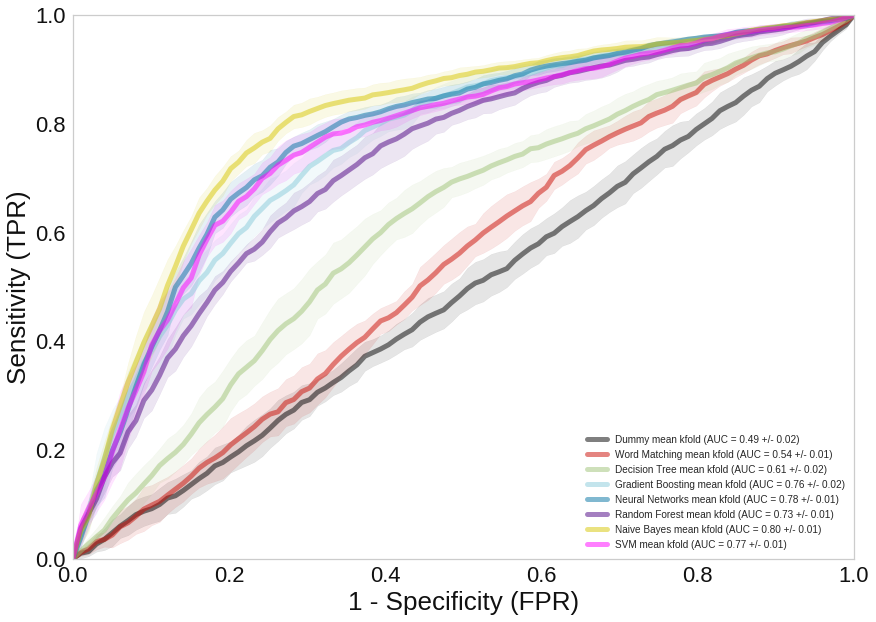

In [386]:
plt = tm.plotROC()
plt.savefig('figures/results/ROC_curve_all_methods.png', bbox_inches='tight')

#### 4.1.1 Student's T-Test relative to Naive Word Matching
Evaluate the difference in performance by applying a t-test

- d_aucs = dictionary with all of the aucs 
- auc_ref = reference auc (in this case the auc of the Word Matching method is used)


In [387]:
d_aucs = tm.getAUC()
auc_ref = d_aucs['Word Matching']
auc_models = d_aucs

for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

Naive Bayes 	(p = 5.585662678845242e-20 )
Word Matching 	(p = 1.0 )
Decision Tree 	(p = 3.951502119254966e-09 )
Gradient Boosting 	(p = 3.2473262896859064e-17 )
Neural Networks 	(p = 5.4905426332066e-20 )
Random Forest 	(p = 1.4267149047754914e-17 )
Dummy 	(p = 8.739917979527275e-06 )
SVM 	(p = 4.891199629421236e-19 )


### 4.2. AUC - Precision Recall curve

Dummy mean kfold (AUPRC = 0.50 +/- 0.02)
Word Matching mean kfold (AUPRC = 0.53 +/- 0.02)
Decision Tree mean kfold (AUPRC = 0.59 +/- 0.02)
Gradient Boosting mean kfold (AUPRC = 0.75 +/- 0.02)
Neural Networks mean kfold (AUPRC = 0.75 +/- 0.01)
Random Forest mean kfold (AUPRC = 0.72 +/- 0.02)
Naive Bayes mean kfold (AUPRC = 0.78 +/- 0.02)
SVM mean kfold (AUPRC = 0.75 +/- 0.02)


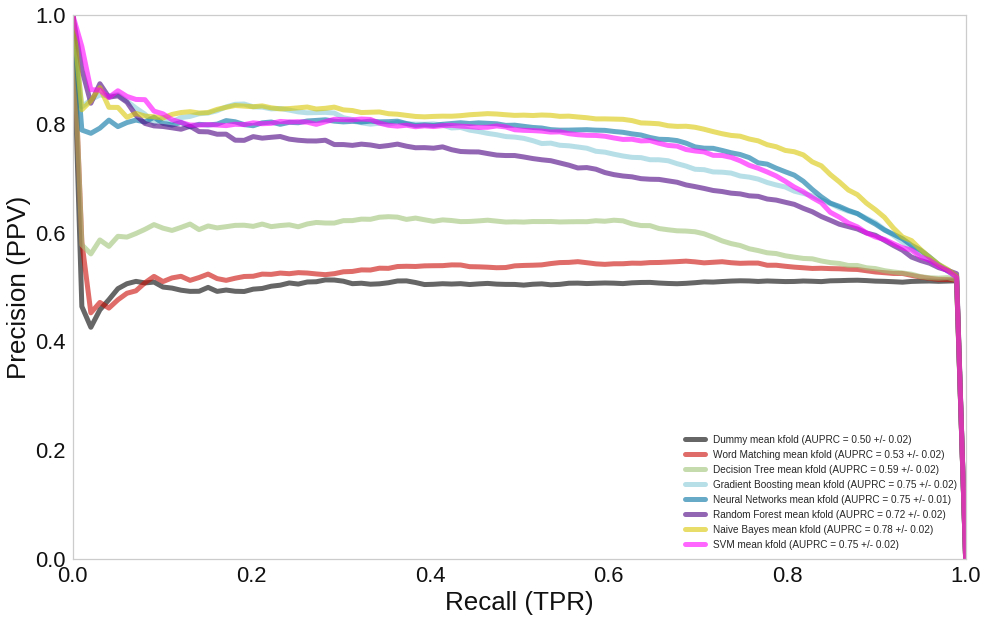

In [388]:
plt = tm.plotPrecisionRecall()
plt.savefig('figures/results/PR_curve_all_methods.png', bbox_inches='tight')

#### 4.2.2 Student's T-Test relative to Naive Word Matching (PR-AUC)

In [389]:
d_auprcs = tm.getAUPRC()
auprc_ref = d_auprcs['Word Matching']
auprc_models = d_auprcs

for key in d_auprcs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_auprcs[key], auprc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

Naive Bayes 	(p = 5.806908143286002e-16 )
Word Matching 	(p = 1.0 )
Decision Tree 	(p = 9.060323825675855e-06 )
Gradient Boosting 	(p = 5.298884101010964e-14 )
Neural Networks 	(p = 7.790164690574744e-16 )
Random Forest 	(p = 1.1542678401939027e-13 )
Dummy 	(p = 0.035398418869891 )
SVM 	(p = 6.977359836202677e-14 )


## Step 5: Distribute Model - save classification model
With pickle you can save & load the models

In [390]:
best_model = tm.getTrainedClassifier('SVM')
filename='savedModels/SVM.sav'
pickle.dump(best_model, open(filename, 'wb'))

### 5.1 Import trained classification model
you can apply this model on a new unlabeled set

In [391]:
filename='savedModels/SVM.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Step 6: Evaluate best Model
Visualize the prediction distribution (probabilities) of the classifier with a swarm plot. 

- You could also draw a scatterplot (by uncommenting the third line)

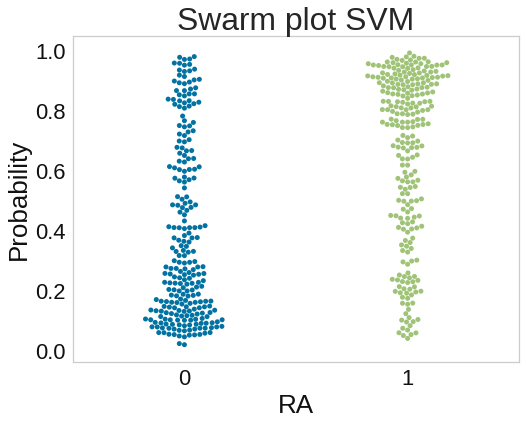

In [377]:
tm.plotSwarm('SVM')
plt.savefig('figures/results/swarmplot_SVM.png', bbox_inches='tight')
# tm.plotScatter('SVM')

### 6.2 Visualize optimal cut-off

#### Example: Optimal threshold when Sensitivity of 0.9 is desired
Returns the threshold corresponding with a sensitivity (TPR in code) of 0.9 and the highest possible precision

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['prc']
Thresh: 0.19 
PRC: 	0.60 
Sens: 	0.92 
Spec: 	0.38
NPV:	0.8173913043478261
ACC:	0.648


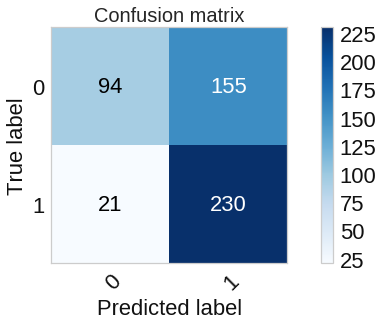

In [378]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=.9, most_val='tpr')

#### Example: Optimal cut-off when Precision of 0.8 is desired
Returns the threshold corresponding with a precision of 0.8 and the highest possible sensitivity

Generating confusion matrix for SVM based on median Iteration (AUPRC):  4
Other weighing variables:  ['tpr']
Thresh: 0.90 
PRC: 	0.81 
Sens: 	0.24 
Spec: 	0.94
NPV:	0.550351288056206
ACC:	0.588


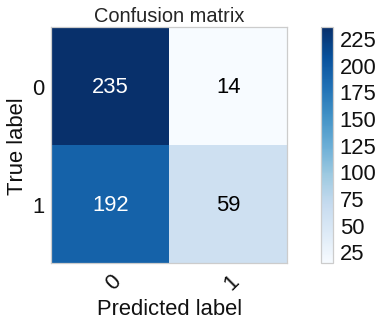

In [382]:
import matplotlib.pylab as pylab
params = {'figure.figsize': (10,5), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm.getConfusionMatrix('SVM', desired=0.8, most_val='prc')

### 6.3 Effect of prevalence on Precision Recall
Applying a trainingsset with a different prevalence every time 

{'Dummy': 'black', 'Word Matching': 'r', 'Decision Tree': 'g', 'Gradient Boosting': 'c', 'Neural Networks': 'b', 'Random Forest': 'indigo', 'Naive Bayes': 'y', 'SVM': 'magenta'}
Prevalence (last iter): 0.2692307692307692
10.0% cases mean kfold (AUPRC = 0.74 +/- 0.02)
Prevalence (last iter): 0.43478260869565216
25.0% cases mean kfold (AUPRC = 0.76 +/- 0.02)
Prevalence (last iter): 0.506
50.0% cases mean kfold (AUPRC = 0.75 +/- 0.02)
Prevalence (last iter): 0.7507418397626113
75.0% cases mean kfold (AUPRC = 0.76 +/- 0.02)
Prevalence (last iter): 0.900355871886121
90.0% cases mean kfold (AUPRC = 0.70 +/- 0.02)
{'50.0': [0.7591952263843593, 0.7359907471176411, 0.7783394052931534, 0.7437180324619557, 0.7132641559057115, 0.7601528024950891, 0.7712489632856084, 0.7478465790516421, 0.7637313904121742, 0.7631825603339127], '75.0': [0.7751993013458244, 0.7497612647944092, 0.7860180754917596, 0.747317911849847, 0.7294398774659558, 0.7714010044795102, 0.7729669896688921, 0.7594545872501336, 0.7368

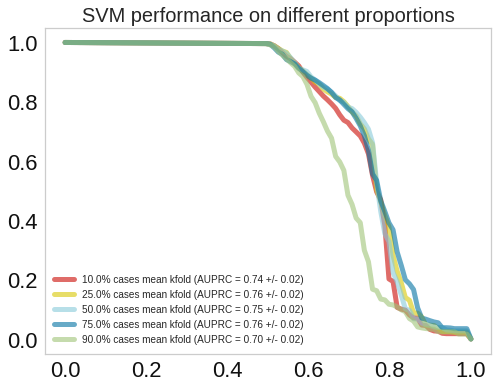

<Figure size 432x432 with 0 Axes>

In [479]:
import TextClassification as tc
import importlib
importlib.reload(tc)

params = {'figure.figsize': (8,6), 'axes.titlesize':20, 'font.weight':'regular', 'xtick.labelsize':22, 'ytick.labelsize':22, 'axes.labelsize':22, 'font.size':22}#fontweight='bold'
pylab.rcParams.update(params)

tm = tc.TextClassification(X, y, models, names)

tm.setSeed(26062019)
tm.setOutputPath(r'output_files/')
tm.binarizeLabel(y, true_label='y')
tm.assignPalette()
tm.setIterations(10)

plt, d_aucs = tm.plotPrevalencePR('SVM', cv=True)
print(d_aucs)

### 6.4 Effect of sample size
Gradually increase the sample size of the trainingsset with a predefined stepsize. Furthermore, you could also choose to apply cross validation (cv) for more robust measurements.
#### ROC

n=100 0.7514460798925722 (std : +/-0.02 )
n=200 0.7575249951015764 (std : +/-0.02 )
n=300 0.7662792122829157 (std : +/-0.02 )
n=400 0.7701148114965273 (std : +/-0.01 )


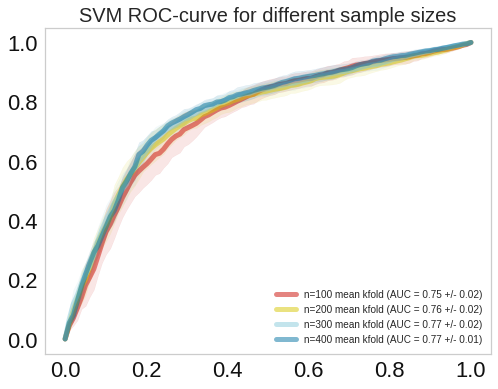

<Figure size 1008x720 with 0 Axes>

In [480]:
plt, d_aucs = tm.samplingCurveROC('SVM', stepsize=100 , cv=True)

#### Precision Recall

n=100 mean kfold (AUPRC = 0.73 +/- 0.04)
n=200 mean kfold (AUPRC = 0.75 +/- 0.03)
n=300 mean kfold (AUPRC = 0.76 +/- 0.03)
n=400 mean kfold (AUPRC = 0.76 +/- 0.02)


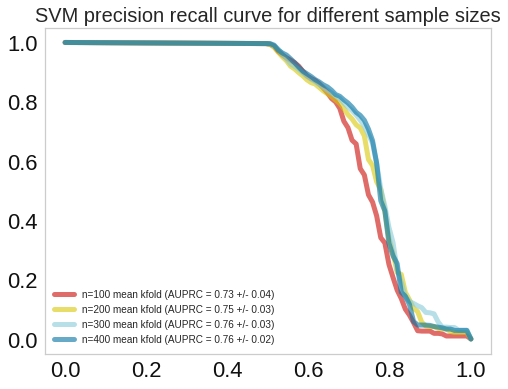

<Figure size 576x432 with 0 Axes>

In [481]:
plt, d_aucs = tm.samplingCurvePR('SVM', stepsize=100 , cv=True)

### 6.4 Apply classifier on gold standard validation set

In [486]:
import pickle

model_name='savedModels/SVM.sav'
file_name='sample_data/gold_dummydata.csv'
text_column='text'

# get EMR text
gold_df = pd.read_csv(file_name, sep=';')
gold_X = gold_df[text_column].values

# apply built model on provided text
loaded_model = pickle.load(open(model_name, 'rb'))
probas_ = loaded_model.predict_proba(gold_X)
pred = probas_[:,1]

# add predictions to table & save predictions
gold_df['prediction'] = gold_df['annotation'].copy()
gold_df['prediction'] = pred
gold_df.to_csv(r'validation/gold_predictions.csv', sep='|', index=False)

gold_df.head()

,annotation,text,patientid,prediction
0,True,van erosie mtp rechts b start hcq dd mg pm ssa...,105.0,0.838065
1,True,artritis psoriatica sine psoriasis reactief pa...,168.0,0.108774
2,True,kristalbewees jicht rf neg erosief ra med etan...,162.0,0.888522
3,True,overname van het haga ivm reistijd momenteel a...,27.0,0.667358
4,True,beeld osteoartritisartralgie hand pols met nu ...,142.0,0.079554


#### Draw ROC curve
Assess the performance of the model on the gold standard EHR-set

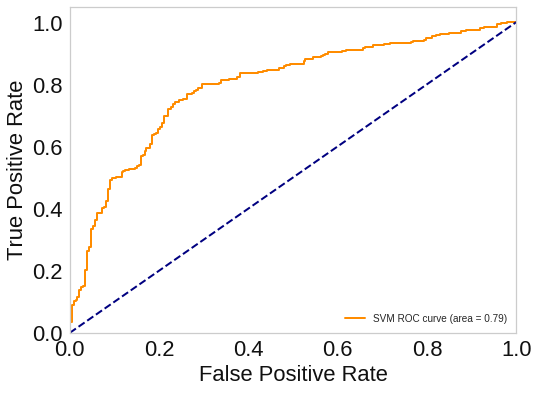

In [489]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(gold_df['annotation'], gold_df['prediction'])
roc_auc = auc(fpr, tpr)

model_name = 'SVM'

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Extra: (Step 7) Visualize most important features 
Optional Visualizations 

Keep in mind: feature importance is not currently working -> so the examples below are general visualizations
### 7.1 Chi-squared test of top 20 features

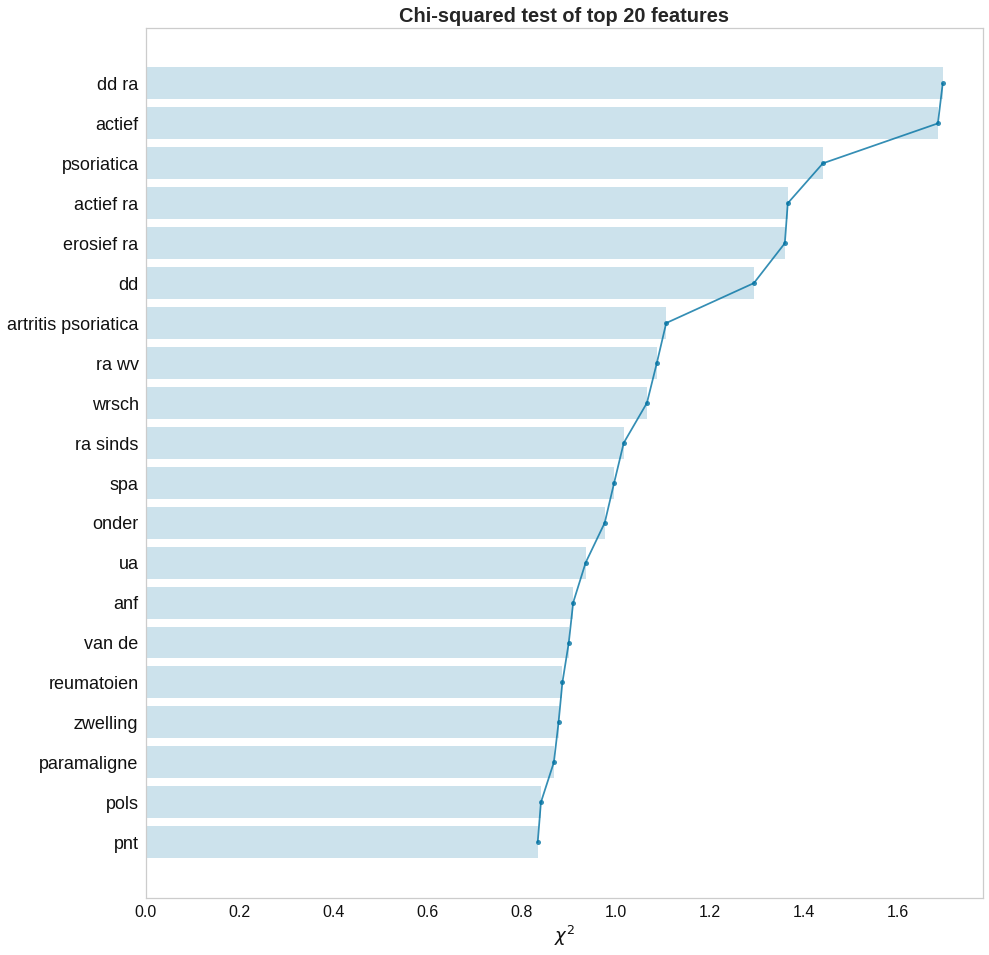

In [396]:
import importlib
importlib.reload(func)

clf, pred, x_train, y_train = tm.getTrainedClassifier('SVM', clf=False)
plt = func.plotFeatureChiSquared(x_train, y_train, nr_features=20, ngram_range=(1,3))

plt.show()

### 7.2 Pearson correlation per feature

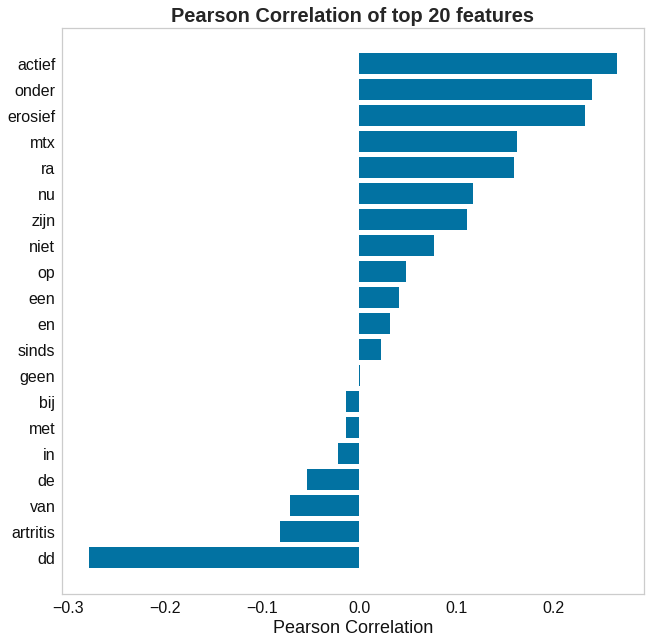

In [397]:
clf, pred, x_train, y_train = tm.getTrainedClassifier('SVM', clf=False)
plt = func.plotFeatureCorrelation(x_train, y_train, nr_features=20, ngram_range=(1,3))
locs, labels = plt.yticks()  

#plt.yticks(locs, ['ra', 'erosive', 'active', 'not-active', 'on', 'rf',  'currently', 'not', 'remission', 'in', 'the', 'with', 'and', 'no', 'arthrosis', 'in case of/by', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
plt.show()

### 7.3 Explained variance per feature according to the best performing model
Feature importance is calculated with the leave-one-out method to assess the explained variance of said feature. In other words: The importance of each feature reflects the model error caused by exclusion of said feature.

- The feature importance can only be calculated for decision tree like classifiers

[FUNCTION STILL WIP]

### 7.4 Trainingset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


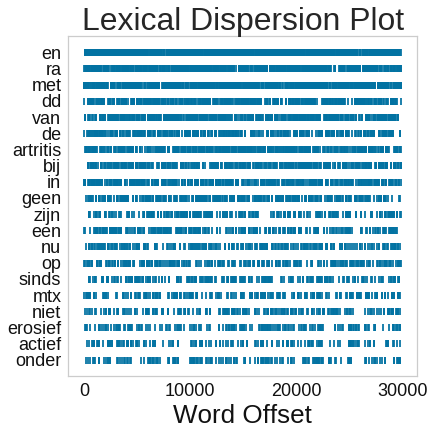

In [398]:
func.plotLexicalDispersion(x_train, ngram_range = (1,1))

### 7.5 Testset | Lexical Dispersion Plot 

In [400]:
func.plotLexicalDispersion(X[test_index], ngram_range = (1,1))

### 7.6 Plot distribution of n=50 prevalent features
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

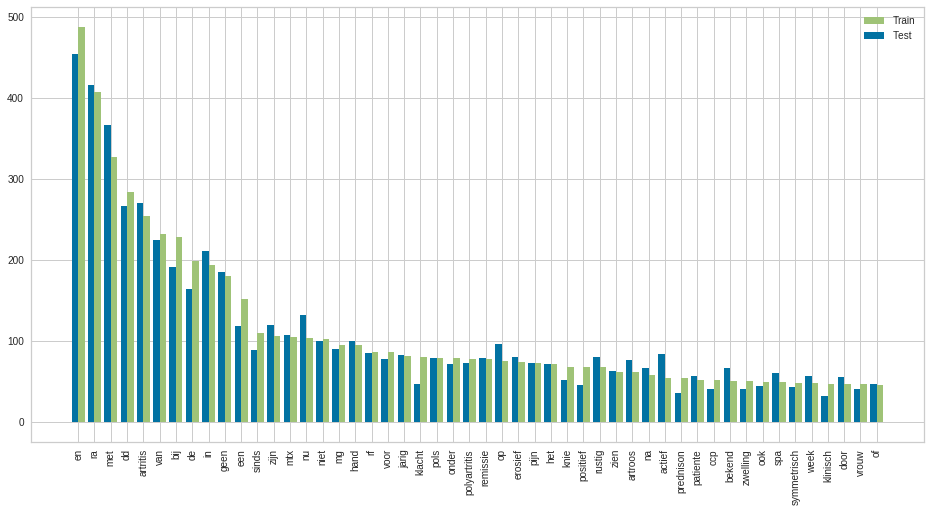

In [91]:
import matplotlib.pyplot as plt

# Assess most prevalent features
func.plotTrainTestDistribution(X[train_index], X[test_index], nr_features=50) 

### 7.7 Graphviz | Write GBM structure to 
Outputs a file that can be visualized in http://viz-js.com/ 
##### Input:
- sub_tree = specify the subtree to draw (0-99 in this case)

In [ ]:
clf, pred, x_train, y_train = tm.getTrainedClassifier('Gradient Boosting', clf=False)

sub_tree = 99

test_clf = tuple(clf)[1] # get classifier
estimator = test_clf.estimators_[sub_tree, 0] 
#print(estimator.feature_names)
lbls = estimator.feature_importances_
vect = clf['vect']
#vect.fit_transform(x_train)
lbls = vect.get_feature_names()
#print(len(lbls))

func.exportTreeGraphViz(x_train, estimator, lbls, 'GBM_structure_subtree' + str(sub_tree))